# Application: Reaction Networks

## Reaction Rates

Nuclear experiments provide us with reaction rates of the form (for a 2-body reaction):

$$r = \frac{n_A n_B}{1 + \delta_{AB}} \langle \sigma v \rangle$$

where $n_A$ is the number density of species A and $n_B$ is the number
density of species B.  The denominator ensures that we don't double
count for a species reacting with itself.  The term $\langle \sigma v
\rangle$ is the average of the cross section and velocity over the
distribution of velocities in the frame of the reaction.  This is what is
measured by experiments.

Here the rate, $r$, has units of reactions / time / volume.


Reaction databases (like ReacLib) often provide fits to $N_A \langle \sigma v
\rangle$, where $N_A$ is Avogadro's number.

## Structure of a Network

A reaction network is a set of nuclei and the rates that link them together.  Consider
4 nuclei, $A$, $B$, $C$, and $D$, linked by 2 rates:

$$A + A \rightarrow B + \gamma$$

$$B + C \rightarrow A + D$$

we would describe these as a set of ODEs for each species.  In terms
of number density, it is straightforward to write down:

\begin{align}
\frac{dn_A}{dt} &= - 2 \frac{1}{2} n_A^2 \langle \sigma v \rangle_{AA}
                     + n_B n_C \langle \sigma v \rangle_{BC} \\
\frac{dn_B}{dt} &= \frac{1}{2} n_A^2 \langle \sigma v \rangle_{AA} 
                     - n_B n_C \langle \sigma v \rangle_{BC} \\
\frac{dn_C}{dt} &= - n_B n_C \langle \sigma v \rangle_{BC} \\
\frac{dn_D}{dt} &=  n_B n_C \langle \sigma v \rangle_{BC} \\
\end{align}

Here the first equation says that we lose 2 nuclei $A$ for each $A + A$ reaction
and we gain 1 nuclei $A$ for each $B + C$ reaction.  The factor of 1/2 in the first
term is because when $A$ reacts with itself, we don't want to double count the number
of pairs.

We can instead write this in terms of molar or mass fractions.  Mass fractions are defined
as the mass of the species relative to the total mass of all species in a volume, or

$$X_k = \frac{\rho_k}{\rho}$$

These have the property

$$\sum_k X_k = 1$$

Molar fractions are scaled by the atomic weight:

$$Y_k = \frac{X_k}{A_k}$$

where $Y_k$ is the molar fraction of species $k$, $X_k$ is the mass fraction, and $A_k$
is the atomic weight.  Number density is related to mass fraction as:

$$n_k = \frac{\rho X_k}{m_u A_k}$$

where $m_u$ is the atomic mass unit ($1/N_A$).

Substituting these into the above expression we get

\begin{align}
\frac{dY_A}{dt} &= - 2 \frac{1}{2} \rho Y_A^2 N_A \langle \sigma v \rangle_{AA}
                     + \rho Y_B Y_C N_A \langle \sigma v \rangle_{BC} \\
\frac{dY_B}{dt} &= \frac{1}{2} \rho Y_A^2 N_A \langle \sigma v \rangle_{AA} 
                     - \rho Y_B Y_C N_A \langle \sigma v \rangle_{BC} \\
\frac{dY_C}{dt} &= - \rho Y_B Y_C N_A \langle \sigma v \rangle_{BC} \\
\frac{dY_D}{dt} &=  \rho Y_B Y_C N_A \langle \sigma v \rangle_{BC} \\
\end{align}

This is often the form we write the system of ODEs in when we write a network.

## Integrating the Network

We often need to integrate this system together with an energy
equation to capture the evolution of the temperature as reactions
progress, since the reaction rates are highly-temperature sensitive.

But even without an energy equation, this system is difficult to
integrate because there can be a wide range of timescales involved in
the reaction rates, which makes the system a *stiff* system of ODEs.
We need to use different methods from the explicit Runge-Kutta methods
we often use.


## CNO Burning

We can use [pynucastro](https://github.com/pynucastro/pynucastro) to generate the righthand side function for an astrophysical reaction network.

We'll create a CNO network that has the rates for all 4 CNO cycles + hot-CNO, as listed here:
[https://reaclib.jinaweb.org/popularRates.php](https://reaclib.jinaweb.org/popularRates.php)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynucastro as pyna

In [2]:
rate_names = ["c12(p,g)n13",
              "c13(p,g)n14",
              "n13(,)c13",
              "n13(p,g)o14",
              "n14(p,g)o15",
              "n15(p,a)c12",
              "o14(,)n14",
              "o15(,)n15",
              "n15(p,g)o16",
              "o16(p,g)f17",
              "f17(,)o17",
              "o17(p,a)n14",
              "o17(p,g)f18",
              "f18(,)o18",
              "o18(p,a)n15",
              "o18(p,g)f19",
              "f19(p,a)o16",
              "o14(a,p)f17",
              "f17(p,g)ne18",
              "ne18(,)f18",
              "f18(p,a)o15"]
rl = pyna.ReacLibLibrary()
rates = rl.get_rate_by_name(rate_names)
rc = pyna.RateCollection(rates=rates)

We can visualize the network and rates linking the nuclei

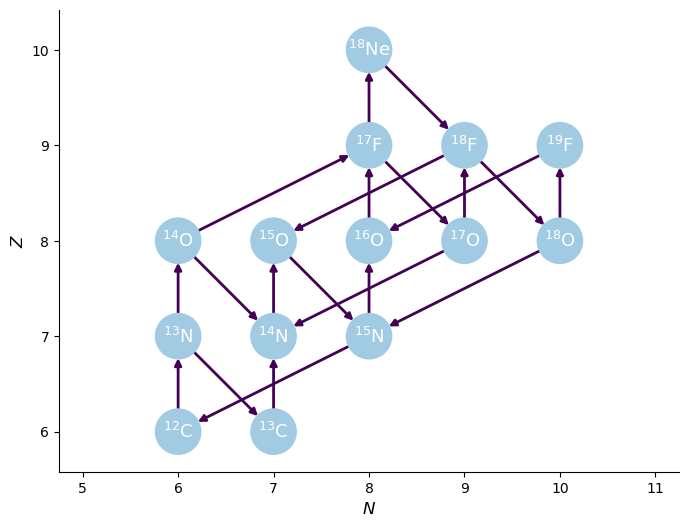

In [3]:
fig = rc.plot()

pynucastro can write out the python code needed to evaluate the reaction rates

In [4]:
pynet = pyna.PythonNetwork(rates=rates)
pynet.write_network("cno_integration_example.py")

In [5]:
#%cat cno_integration_example.py

Now we can import the network that was just created

In [6]:
import cno_integration_example as cno

We'll use the BDF solver from SciPy

In [7]:
from scipy.integrate import solve_ivp

Now we'll set the thermodynamic conditions.  We initialize mass fractions and then convert to molar fractions, since that's what the RHS uses

In [8]:
rho = 150
T = 1.5e7

X0 = np.zeros(cno.nnuc)
X0[cno.jp] = 0.7
X0[cno.jhe4] = 0.28
X0[cno.jc12] = 0.02

Y0 = X0/cno.A

In [9]:
Y0

array([0.7       , 0.07      , 0.00166667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [10]:
tmax = 1.e20

sol = solve_ivp(cno.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-6)

In [11]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04 ...  7.679e+19  1.000e+20]
        y: [[ 7.000e-01  7.000e-01 ...  5.177e-09  2.786e-10]
            [ 7.000e-02  7.000e-02 ...  2.441e-01  2.441e-01]
            ...
            [ 0.000e+00  3.467e-153 ...  1.275e-09  1.275e-09]
            [ 0.000e+00  1.098e-119 ... -1.564e-55 -4.073e-60]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f3e93b7d3a0>
 t_events: None
 y_events: None
     nfev: 345
     njev: 20
      nlu: 63

Now we can plot the mass fractions.

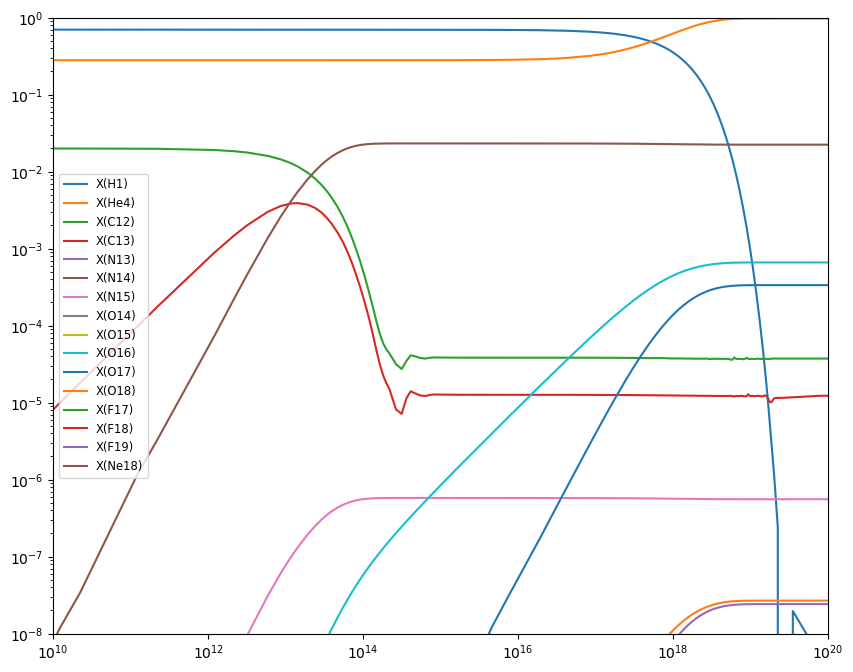

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

for n in range(cno.nnuc):
    ax.loglog(sol.t, sol.y[n,:] * cno.A[n], label=f"X({cno.names[n].capitalize()})")

ax.set_xlim(1.e10, 1.e20)
ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")

fig.set_size_inches((10, 8))